Dataset: Kaggle Alzeihmer Dataset, which includes 2 subfolders train and test


Runtime type:
1. T4 GPU: Part 1,2,3
2. TPU v2-8: Part 4



Below are model/variables being saved in ModelCheckpoint folder

Part 1:
1. model_1

Part 2:
2. Zcode_training
3. Zcode_training_noshuffle

Part 3
4. combined_training_data
5. combined_training_data_labels
6. Zcode_testing
7. combined_training_data_noshuffle
8. combined_training_data_noshuffle_labels

Part 4:
9. classifier

Note:
- model_1 will only save the best model
- the rest of model/variables will be re-newed every time.



In [ ]:
# mount gdrive with this code
from google.colab import drive
drive.mount('/content/drive')
#below where the file is in gdrive, change with your
data_path =  "/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets"

Mounted at /content/drive


# PART 0 STARTS ___________________

In [ ]:
# import packages
import tensorflow as tf
from math import ceil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.manifold import TSNE

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, ResNet152V2
from tensorflow.keras.callbacks import ModelCheckpoint

from imblearn.over_sampling import SMOTE

from keras.models import load_model

from IPython.display import display
from PIL import Image

In [ ]:
Original_Train ='/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Kaggle Alzheimers Dataset/train'
Original_Test = '/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Kaggle Alzheimers Dataset/test'

In [ ]:
batch_size = 32
numClasses = 4
img_height, img_width, chan_count = 224,224,3


data = ImageDataGenerator(rescale=1.0 / 255)

training_data = data.flow_from_directory(
    Original_Train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # subset='training',
    shuffle=True
)

training_data_noshuffle = data.flow_from_directory(
   Original_Train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # subset='training',
    shuffle=False
)

test_data = data.flow_from_directory(
    Original_Test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # subset='validation',
    shuffle=False
)


Found 5121 images belonging to 4 classes.
Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
training_data.class_indices

{'MildImpairment': 0,
 'ModerateImpairment': 1,
 'NoImpairment': 2,
 'VeryMildImpairment': 3}

In [ ]:
# Get the class labels from the training data
train_labels = training_data.labels

# Count the occurrences of each class
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Print the results
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} data points")

Class 0: 717 data points
Class 1: 52 data points
Class 2: 2560 data points
Class 3: 1792 data points


Determine majority and minority class

In [ ]:
# Get the class labels from the training data
train_labels = training_data.labels

# Count the occurrences of each class
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Find the majority class (the class with the highest count)
majority_class = [unique_classes[np.argmax(class_counts)]]  # Class with the highest count

# Find the minority classes (all other classes)
minority_class = [cls for cls in unique_classes if cls not in majority_class]

# Print the results
print(f"Majority Class: {majority_class}")
print(f"Minority Classes: {minority_class}")


Majority Class: [2]
Minority Classes: [0, 1, 3]


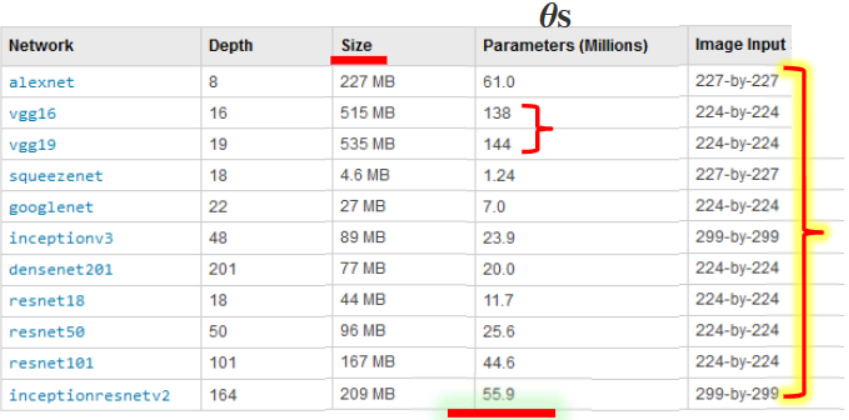

# PART 0 ENDS _______________________________________

# PART 1 STARTS _______________

base_model/ transfer learning setup

In [ ]:
# Load transfer learning model with pretrained weights, exclude top layers
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers[-50:]:  # Fine-tune the last 50 layers
    layer.trainable = True



In [ ]:
base_model.summary()

Model: "resnet152v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 58,331,648 (222.52 MB)

 Trainable params: 58,187,904 (221.97 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [ ]:
visibleL = Input(shape=(img_height, img_width, chan_count), name='Input')
hidden1 = base_model(visibleL)
hidden2= Flatten(name='f1')(hidden1)
hidden3 = Dense(1024, activation='relu', name='d1')(hidden2)
hidden4 = Dropout(0.3, name='d2')(hidden3)
hidden5 = Dense(512, activation='relu', name='d3')(hidden4)
hidden6 = Dropout(0.3, name='d4')(hidden5)
hidden7 = Dense(256, activation='relu', name='d5')(hidden6)
hidden8 = Dropout(0.3, name='d6')(hidden7)
output = Dense(numClasses, activation='softmax', name='output')(hidden8)

model_1 setup

In [ ]:
# Create the model
model_1 = Model(inputs=visibleL, outputs=output)

In [ ]:
opt_finetune = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model_1.compile(loss='categorical_crossentropy', optimizer=opt_finetune, metrics=['accuracy'])


In [ ]:
model_save = ModelCheckpoint('/content/drive/My Drive/AI - Fall 2024/Final Project v.2/ModelCheckpoint/ResNet152V2_model_1.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
# Train the model
history = model_1.fit(
    training_data,
    validation_data=test_data,
    epochs=200,
    batch_size = 50,
    callbacks=[model_save]
)

Epoch 1/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.3825 - loss: 1.6731 - val_accuracy: 0.5215 - val_loss: 1.0460
Epoch 2/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 124s 752ms/step - accuracy: 0.4732 - loss: 1.3117 - val_accuracy: 0.5160 - val_loss: 1.0198
Epoch 3/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 128s 790ms/step - accuracy: 0.4928 - loss: 1.1719 - val_accuracy: 0.5504 - val_loss: 0.9317
Epoch 4/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 132s 805ms/step - accuracy: 0.5397 - loss: 1.0553 - val_accuracy: 0.5723 - val_loss: 0.9237
Epoch 5/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 121s 748ms/step - accuracy: 0.5672 - loss: 1.0051 - val_accuracy: 0.5723 - val_loss: 0.9060
Epoch 6/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 128s 790ms/step - accuracy: 0.6134 - loss: 0.9190 - val_accuracy: 0.6153 - val_loss: 0.8359
Epoch 7/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 130s 792ms/step - accuracy: 0.6123 - loss: 0.8918 - val_accuracy: 0.6239 - val_loss: 0.8344
Epoch 8/200
161/161 ━━━━━━━━━━━━━━━━━━━━ 130s 791ms/step - accuracy: 0.6

Accuracy and Loss vs Epoch of model_1

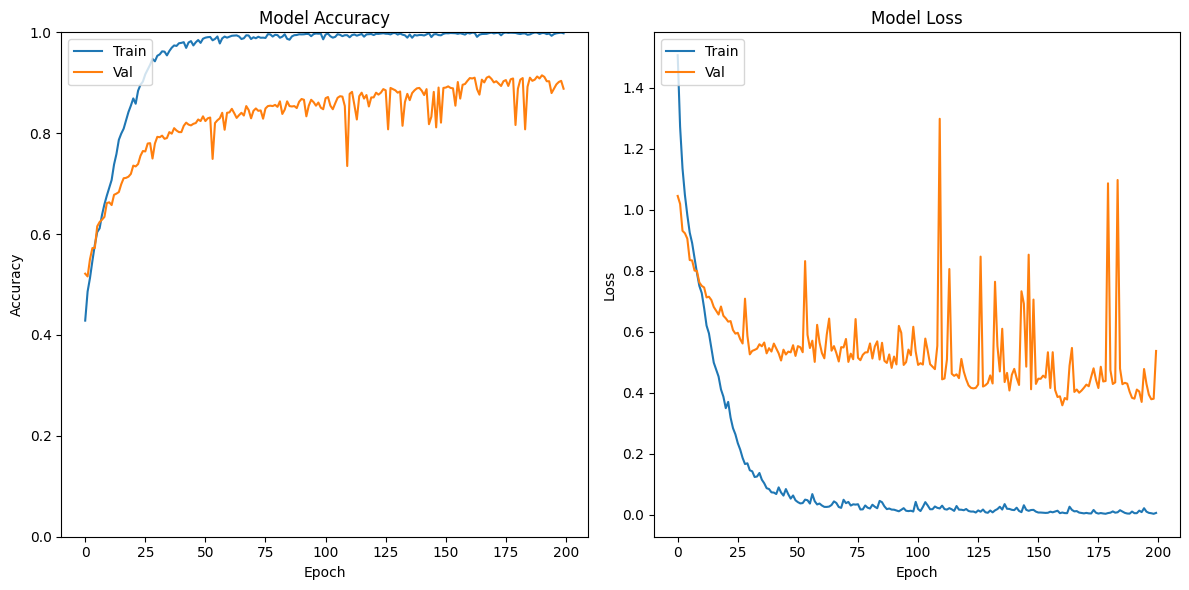

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper left')
plt.ylim(0,1)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.tight_layout()  # Adjust spacing between plots
plt.show()

Training and Testing Classification report in model_1

In [ ]:
model_1= load_model('/content/drive/My Drive/AI - Fall 2024/Final Project v.2/ModelCheckpoint/ResNet152V2_model_1.keras')

In [ ]:
training_data.reset()
test_data.reset()

predicted_scores = model_1.predict(training_data_noshuffle, verbose=1)
predicted_labels = predicted_scores.argmax(axis=1)

train_labels = training_data_noshuffle.labels

acc_score = accuracy_score(train_labels, predicted_labels)
CFM = confusion_matrix(train_labels, predicted_labels)

print("\n", "Accuracy of Training Dataset: " + str(format(acc_score,'.3f')))
print("\n", "CFM of Training Dataset: \n", confusion_matrix(train_labels, predicted_labels))
print("\n", "Classification report of Training Dataset: \n", classification_report(train_labels, predicted_labels))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 1096s 7s/step

 Accuracy of Training Dataset: 1.000

 CFM of Training Dataset: 
 [[ 717    0    0    0]
 [   0   52    0    0]
 [   0    0 2560    0]
 [   0    0    0 1792]]

 Classification report of Training Dataset: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       717
           1       1.00      1.00      1.00        52
           2       1.00      1.00      1.00      2560
           3       1.00      1.00      1.00      1792

    accuracy                           1.00      5121
   macro avg       1.00      1.00      1.00      5121
weighted avg       1.00      1.00      1.00      5121



In [ ]:
training_data.reset()
test_data.reset()

predicted_scores_test = model_1.predict(test_data, verbose=1)
predicted_labels_test = predicted_scores_test.argmax(axis=1)

test_labels = test_data.labels

acc_score_test = accuracy_score(test_labels, predicted_labels_test)
CFM_test = confusion_matrix(test_labels, predicted_labels_test)

print("\n", "Accuracy of Testing Dataset: " + str(format(acc_score_test,'.3f')))
print("\n", "CFM of Testing Dataset: \n", confusion_matrix(test_labels, predicted_labels_test))
print("\n", "Classification report of Testing Dataset: \n", classification_report(test_labels, predicted_labels_test))

 1/40 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step

 Accuracy of Testing Dataset: 0.915

 CFM of Testing Dataset: 
 [[159   0   4  16]
 [  0  11   0   1]
 [  8   0 613  19]
 [ 11   0  50 387]]

 Classification report of Testing Dataset: 
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       179
           1       1.00      0.92      0.96        12
           2       0.92      0.96      0.94       640
           3       0.91      0.86      0.89       448

    accuracy                           0.91      1279
   macro avg       0.93      0.91      0.92      1279
weighted avg       0.91      0.91      0.91      1279



# PART 1 ENDS ____________________

# PART 2

# Extra Graphs for Unbalanced Datset

6. Graph tsne of Training and Testing dataset

6a. Create a model_3 from classifier model (step #5) to get Zcode of combined_training_data and Zcode_testing

In [ ]:
tsne_model = Model(inputs=model_1.input, outputs=model_1.get_layer('d6').output)

6b. Zcode

In [ ]:
# Feature extraction of combined_training_data and Zcode_testing
tsne_training = tsne_model.predict(training_data_noshuffle)
tsne_testing = tsne_model.predict(test_data)

print('Shape of Combined Training Data-NoShuffle after feature extraction for tsne graph is: ', tsne_training.shape)
print('Shape of Testing Data after feature extraction for tsne graph is',tsne_testing.shape)

161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step
Shape of Combined Training Data-NoShuffle after feature extraction for tsne graph is:  (5121, 256)
Shape of Testing Data after feature extraction for tsne graph is (1279, 256)


6c. tsne on the Zcode (step #6b)

In [ ]:
# tsne Z_code to 2-D

# Define TSNE instance
tsne_train = TSNE(n_components=2, verbose=1, random_state=0, perplexity=min(30, tsne_training.shape[0] - 1))
tsne_test = TSNE(n_components=2, verbose=1, random_state=0, perplexity=min(30, tsne_testing.shape[0] - 1))

# Define TSNE instance for testing data with adjusted perplexity
tsne_training = tsne_train.fit_transform(tsne_training)
tsne_testing = tsne_test.fit_transform(tsne_testing)

print("TSNE results for training data:", tsne_training.shape)
print("TSNE results for testing data:", tsne_testing.shape)

X1,y1 = tsne_training[:,0], tsne_training[:,1]
X2,y2 = tsne_testing[:,0], tsne_testing[:,1]


print(X1.shape, y1.shape)
print(X2.shape, y2.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5121 samples in 0.001s...
[t-SNE] Computed neighbors for 5121 samples in 0.261s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5121
[t-SNE] Computed conditional probabilities for sample 2000 / 5121
[t-SNE] Computed conditional probabilities for sample 3000 / 5121
[t-SNE] Computed conditional probabilities for sample 4000 / 5121
[t-SNE] Computed conditional probabilities for sample 5000 / 5121
[t-SNE] Computed conditional probabilities for sample 5121 / 5121
[t-SNE] Mean sigma: 2.380879
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.345863
[t-SNE] KL divergence after 1000 iterations: 2.361824
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1279 samples in 0.001s...
[t-SNE] Computed neighbors for 1279 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1279
[t-SNE] Computed conditional probabilities for sample 1279 / 1279
[t-SNE] Mean sigma: 2.886057


6d. Plot tsne

[Text(0.5, 1.0, 'tsne of Zcode of testing')]

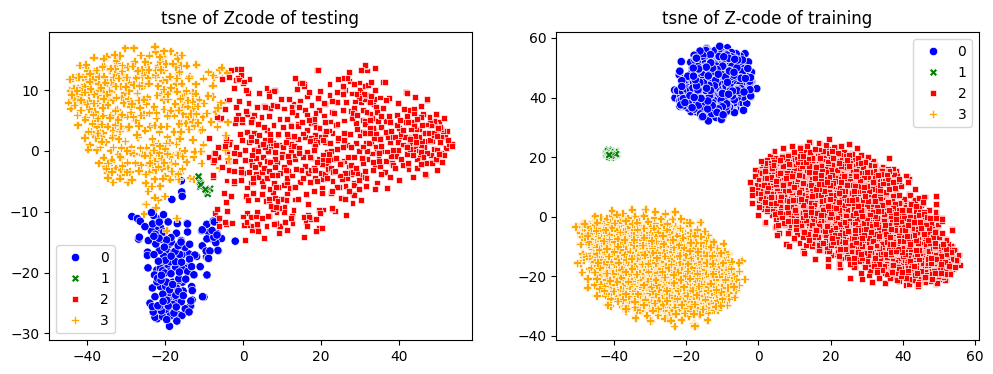

In [ ]:

y_1D_train = predicted_labels
y_1D_test = predicted_labels_test

f, axes = plt.subplots(1, 2,figsize=(12,4))

# Define a dictionary mapping class labels to colors
palette_dict = {
    0: 'blue',  # Class 0 will be blue
    1: 'green',  # Class 1 will be green
    2: 'red',  # Class 2 will be red
    3: 'orange'  # Class 3 will be magenta
}


sns.scatterplot(x = X1, y = y1, palette = palette_dict, style = y_1D_train, hue = y_1D_train, legend = 'full', ax = axes[1]).set(title='tsne of Z-code of training')
sns.scatterplot(x = X2, y = y2, palette = palette_dict, style = y_1D_test, hue = y_1D_test, legend = 'full', ax = axes[0]).set(title='tsne of Zcode of testing')



7. ROC Curve

In [ ]:
# Compute ROC curve and ROC area for each class
## Calculate ROC curves and AUCs for all classes
roc_curves = {}
for i, class_label in enumerate(unique_classes):
    fpr, tpr, _ = roc_curve(test_labels, predicted_scores_test[:, i], pos_label=class_label)
    roc_auc = auc(fpr, tpr)
    roc_curves[class_label] = (fpr, tpr, roc_auc)
    print(f"roc_auc_{class_label}: {roc_auc:.2f}")

roc_auc_0: 0.99
roc_auc_1: 1.00
roc_auc_2: 0.98
roc_auc_3: 0.97


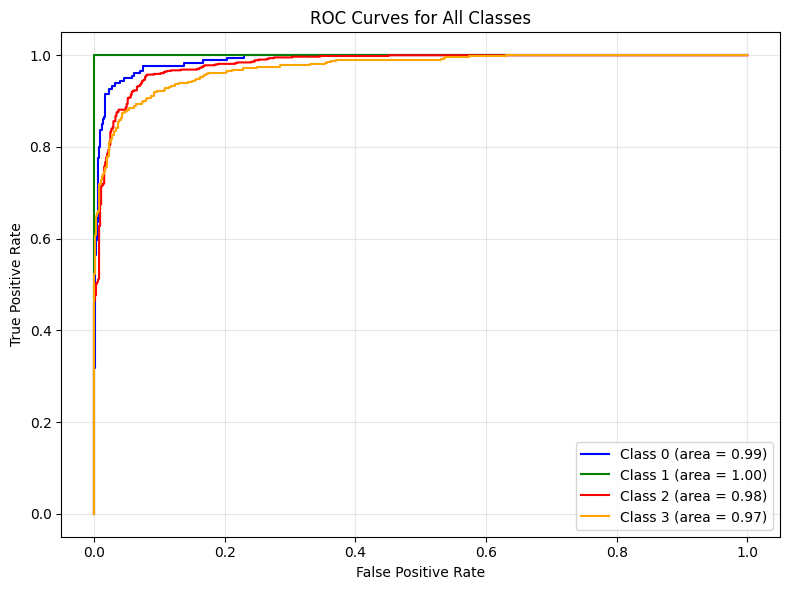

In [ ]:
# Define a list of colors
colors = ['blue', 'green', 'red', 'orange']

# Plot ROC curves for all classes
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(unique_classes):
    fpr, tpr, roc_auc = roc_curves[class_label]
    plt.plot(
        fpr, tpr,
        label=f'Class {class_label} (area = {roc_auc:.2f})',
        color=colors[i % len(colors)]
    )

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()